In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# os.makedirs('/content')
!unzip "/content/drive/MyDrive/ITRI/screwnut.zip" -d /content

Archive:  /content/drive/MyDrive/ITRI/screwnut.zip
   creating: /content/dataset/01/
  inflating: /content/dataset/01/IMG_3698.jpeg  
  inflating: /content/dataset/01/IMG_3699.jpeg  
  inflating: /content/dataset/01/IMG_3700.jpeg  
  inflating: /content/dataset/01/IMG_3701.jpeg  
  inflating: /content/dataset/01/IMG_3702.jpeg  
  inflating: /content/dataset/01/IMG_3703.jpeg  
  inflating: /content/dataset/01/IMG_3704.jpeg  
  inflating: /content/dataset/01/IMG_3705.jpeg  
  inflating: /content/dataset/01/IMG_3706.jpeg  
  inflating: /content/dataset/01/IMG_3707.jpeg  
  inflating: /content/dataset/01/IMG_3708.jpeg  
  inflating: /content/dataset/01/IMG_3709.jpeg  
  inflating: /content/dataset/01/IMG_3710.jpeg  
  inflating: /content/dataset/01/IMG_3711.jpeg  
  inflating: /content/dataset/01/IMG_3712.jpeg  
  inflating: /content/dataset/01/IMG_3713.jpeg  
  inflating: /content/dataset/01/IMG_3714.jpeg  
  inflating: /content/dataset/01/IMG_3715.jpeg  
  inflating: /content/dataset/01/

In [3]:
# modify dataset
import cv2
import os
import random
import numpy as np


def add_noise(image, mean=0, std=25):
    row, col, ch = image.shape
    gauss = np.random.normal(mean, std, (row, col, ch))
    noisy_image = np.clip(image + gauss, 0, 255)
    return noisy_image.astype(np.uint8)

def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def flip_image(image, flip_code):
    flipped_image = cv2.flip(image, flip_code)
    return flipped_image

def save_image_with_suffix(image, output_directory, original_filename):
    base_filename, file_extension = os.path.splitext(original_filename)
    output_filename = f"{base_filename}_processed{file_extension}"

    index = 1
    while os.path.exists(os.path.join(output_directory, output_filename)):
        output_filename = f"{base_filename}_processed_{index}{file_extension}"
        index += 1

    output_path = os.path.join(output_directory, output_filename)
    cv2.imwrite(output_path, image)

def generate(directory):
  directoryFile = os.listdir(directory) * 2
  for filename in directoryFile:
      if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):

          image_path = os.path.join(directory, filename)
          image = cv2.imread(image_path)

          augmentations = ["rotate", "flip", "noise"]
          chosen_augmentations = random.sample(augmentations, k=random.randint(1, len(augmentations)))

          for augmentation in chosen_augmentations:
              if augmentation == "rotate":
                  angle = random.choice([90, 180, 270, 360])
                  image = rotate_image(image, angle)
              elif augmentation == "flip":
                  flip_code = random.randint(-1, 1)
                  image = flip_image(image, flip_code)
              elif augmentation == "noise":
                  image = add_noise(image)

          save_image_with_suffix(image, directory, filename)

generate("/content/dataset/01")
generate("/content/dataset/02")
generate("/content/dataset/03")

In [4]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import os
import os.path
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
ok_dir = "/content/dataset/01"
noFangs_dir = "/content/dataset/02"
noHexagons_dir = "/content/dataset/03"

classes = ['OK', 'No Fangs', 'No Hexagons']

In [6]:
print("OK data: ", len(os.listdir(ok_dir)))
print("No Fangs data: ", len(os.listdir(noFangs_dir)))
print("No Hexagons data: ", len(os.listdir(noHexagons_dir)))

OK data:  291
No Fangs data:  288
No Hexagons data:  198


In [7]:
def normalisasi(e):
  image = cv2.imread(e)
  image = cv2.resize(image, (224, 224))
  return image.astype('float32') / 255.0

ok_files = [normalisasi(os.path.join(ok_dir, f)) for f in os.listdir(ok_dir)]
noFangs_files = [normalisasi(os.path.join(noFangs_dir, f)) for f in os.listdir(noFangs_dir)]
noHexagons_files = [normalisasi(os.path.join(noHexagons_dir, f)) for f in os.listdir(noHexagons_dir)]

ok_labels = [0] * len(ok_files)
noFangs_labels = [1] * len(noFangs_files)
noHexagons_labels = [2] * len(noHexagons_files)

files = ok_files + noFangs_files + noHexagons_files
labels = ok_labels + noFangs_labels + noHexagons_labels

files, labels = shuffle(files, labels, random_state=42)

train_files, test_files, train_labels, test_labels = train_test_split(files, labels, test_size=0.21, random_state=42)

train_files = np.array(train_files)
train_annotations_array = np.array(train_labels)
test_files = np.array(test_files)
test_annotations_array = np.array(test_labels)

train_annotations_one_hot = to_categorical(train_annotations_array, num_classes=3)
test_annotations_one_hot = to_categorical(test_annotations_array, num_classes=3)

print("Jumlah data pelatihan:", len(train_files))
print("Jumlah data pengujian:", len(test_files))

Jumlah data pelatihan: 613
Jumlah data pengujian: 164


In [8]:
train_annotations_one_hot

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [9]:
model = Sequential(name='Defect_Model')
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))  # Menambahkan dropout
model.add(Dense(3, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "Defect_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 96)       

In [10]:
import time

log_base = '/content/logs/' + time.strftime("%Y%m%d%H%M%S", time.localtime())
model_dir = log_base + '/models/'
os.makedirs(model_dir)

In [11]:
log_dir = os.path.join(log_base, 'log')
model_cbk = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = tf.keras.callbacks.ModelCheckpoint(model_dir + '/Defect_Model.h5',
                                        monitor='accuracy',
                                        save_best_only=True,
                                        mode='min')

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_files, train_annotations_one_hot, epochs=40, batch_size=32, validation_data=(test_files, test_annotations_one_hot), callbacks=[model_cbk, model_mckp, early_stopping])

Epoch 1/40
20/20 [==============================] - 15s 120ms/step - loss: 1.0833 - accuracy: 0.3654 - val_loss: 1.1105 - val_accuracy: 0.3963
Epoch 2/40
 1/20 [>.............................] - ETA: 1s - loss: 1.0656 - accuracy: 0.4375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 1s 58ms/step - loss: 1.0566 - accuracy: 0.4502 - val_loss: 1.0792 - val_accuracy: 0.4146
Epoch 3/40
20/20 [==============================] - 1s 61ms/step - loss: 0.9941 - accuracy: 0.5253 - val_loss: 1.0430 - val_accuracy: 0.4207
Epoch 4/40
20/20 [==============================] - 1s 59ms/step - loss: 0.9063 - accuracy: 0.5661 - val_loss: 0.9969 - val_accuracy: 0.4756
Epoch 5/40
20/20 [==============================] - 1s 58ms/step - loss: 0.8329 - accuracy: 0.6264 - val_loss: 0.9786 - val_accuracy: 0.5732
Epoch 6/40
20/20 [==============================] - 1s 59ms/step - loss: 0.7774 - accuracy: 0.6754 - val_loss: 0.8635 - val_accuracy: 0.6402
Epoch 7/40
20/20 [==============================] - 1s 59ms/step - loss: 0.7069 - accuracy: 0.7145 - val_loss: 0.8226 - val_accuracy: 0.6341
Epoch 8/40
20/20 [==============================] - 1s 59ms/step - loss: 0.6064 - accuracy: 0.7830 - val_loss: 0.8706 - val_accuracy: 0.6159
Epoch 9/40
20/20 [======

In [ ]:
model.save('Defect_Model_' + time.strftime("%Y%m%d%H%M%S", time.localtime()) + '.h5')
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:

test_loss, test_accuracy = model.evaluate(test_files, test_annotations_one_hot)
print(f'Test accuracy: {test_accuracy}')

5/5 [==============================] - 0s 25ms/step - loss: 0.0109 - accuracy: 1.0000
Test accuracy: 1.0


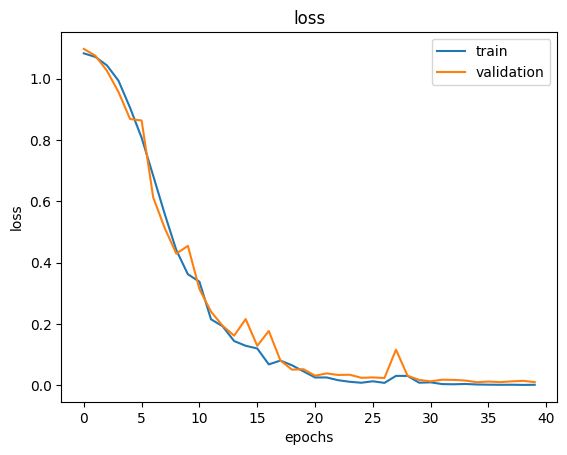

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

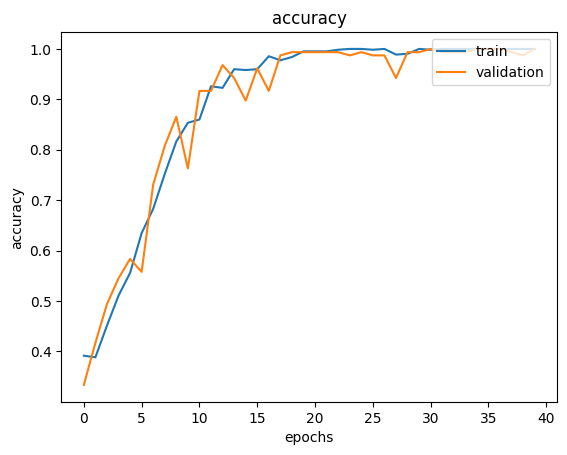

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
# plt.ylim(0.0, 0.01)
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper right')

In [ ]:
loss, accuracy = model.evaluate(test_files, test_annotations_one_hot)
print ("loss: {}, accuracy: {}".format(loss, accuracy))

5/5 [==============================] - 0s 25ms/step - loss: 0.0396 - accuracy: 0.9808
loss: 0.0396270789206028, accuracy: 0.9807692170143127


6/6 [==============================] - 0s 23ms/step - loss: 1.0975 - accuracy: 0.3841
Test accuracy: 0.3841463327407837
6/6 [==============================] - 0s 18ms/step
0


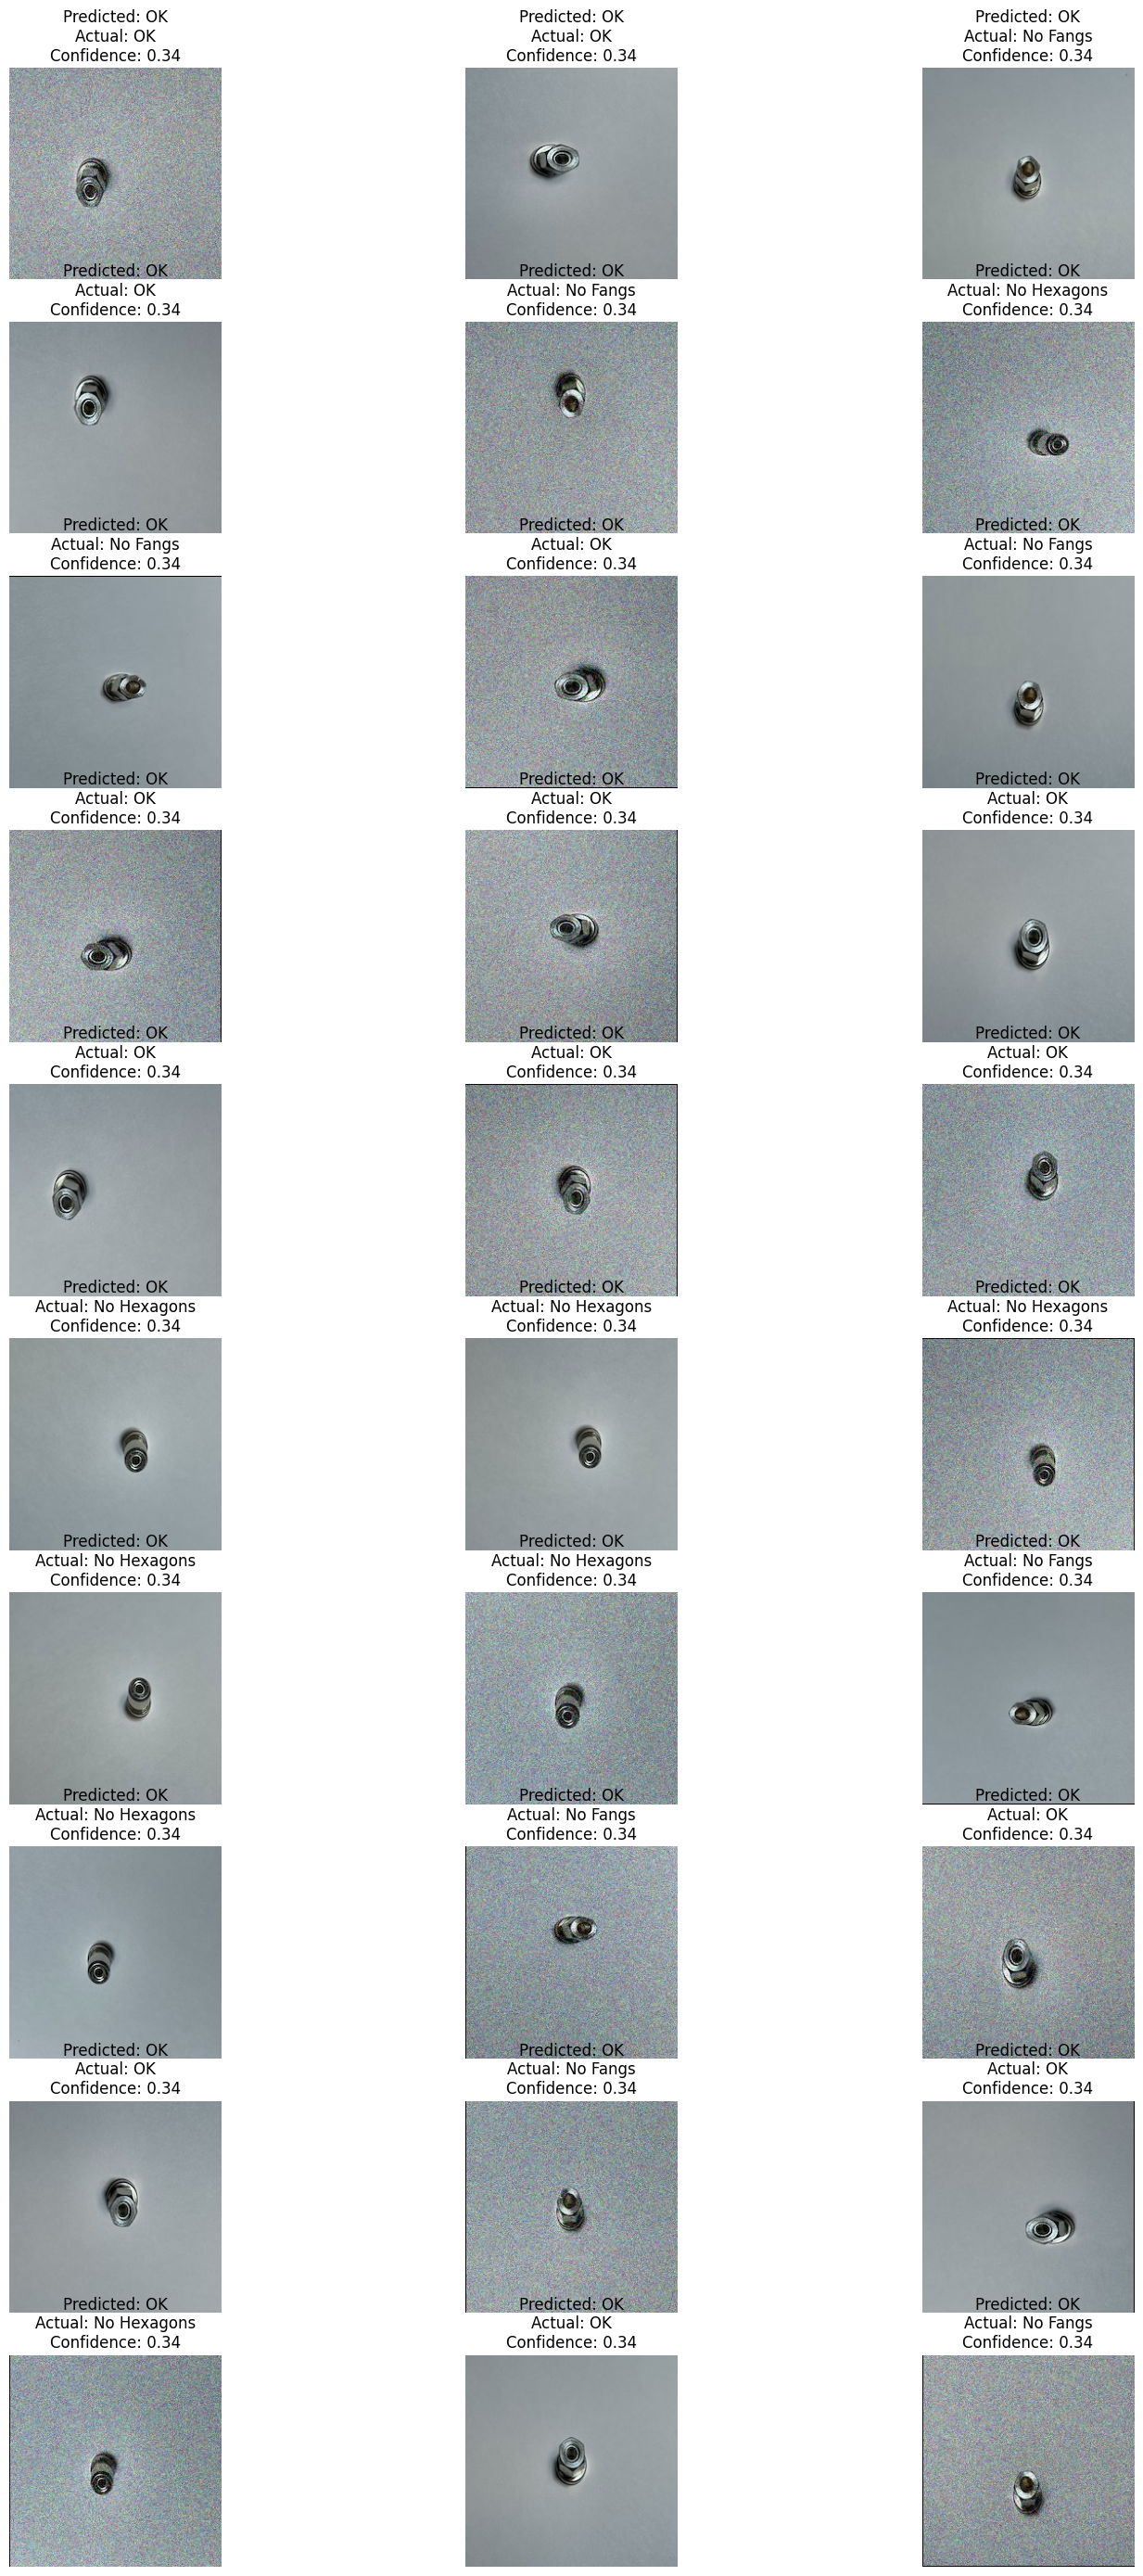

In [ ]:
import numpy as np

test_loss, test_accuracy = model.evaluate(test_files, test_annotations_one_hot)
print(f'Test accuracy: {test_accuracy}')


predictions = model.predict(test_files)

random_indices = np.random.choice(len(test_files), size=30, replace=False)

wrong_predict = 0;

plt.figure(figsize=(18, 35))
for i, idx in enumerate(random_indices):
    predicted_label = np.argmax(predictions[idx])
    confidence = predictions[idx][predicted_label]
    actual_label = test_annotations_array[idx]
    if(classes[predicted_label] != classes[actual_label]):
      wrong_predict+1
    plt.subplot(10, 3, i + 1)
    plt.imshow(test_files[idx])
    plt.title(f'Predicted: {classes[predicted_label]}\nActual: {classes[actual_label]}\nConfidence: {confidence:.2f}')
    plt.axis('off')
print(wrong_predict)
plt.show()



In [ ]:
!cp -r '/content/Defect_Model_Best.h5' '/content/drive/MyDrive/ITRI ScrewNuts/Model'